In [1]:
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib
import scipy as sp

import sys
sys.path.insert(0, '../../')
import DLDMD as dl
import LossDLDMD as lf
import Data as dat
import Training as tr

%matplotlib inline

In [2]:
def edmd(x, num_pred):
    x = tf.transpose(x, perm=[0, 2, 1])
    x_m = x[:, :, :-1]
    x_p = x[:, :, 1:]
    
    S, U, V = tf.linalg.svd(x_m, compute_uv=True, full_matrices=False)
    sm = np.max(S)
    r = S.shape[-1]
    Sri = tf.linalg.diag(1./S[:, :r])
    Ur = U[:, :, :r]
    Urh = tf.linalg.adjoint(Ur)
    Vr = V[:, :, :r]
    
    kmat = x_p @ Vr @ Sri @ Urh
    evals, evecs = tf.linalg.eig(kmat)
    phim = tf.linalg.solve(evecs, tf.cast(x_m, dtype=tf.complex128))
    x0 = phim[:, :, 0]
    x0 = x0[:, :, tf.newaxis]
    
    pred = tf.TensorArray(tf.complex128, size=num_pred)
    pred = pred.write(0, evecs @ x0)
    evals_iter = tf.identity(evals)
    for ii in range(num_pred):
        tmp = evecs @ tf.linalg.diag(evals_iter) @ x0
        pred = pred.write(ii, tmp)
        evals_iter = evals_iter * evals
    pred = tf.transpose(tf.squeeze(pred.stack()), perm=[1, 2, 0])
    return phim, evals, evecs, pred

# Setup

In [3]:
# Figure parameters
plot_save_path = './analysis_results/'
font = {'family': 'DejaVu Sans', 'size': 18}
matplotlib.rc('font', **font)
fontsize = 18
figsize = (15, 10)
dpisave = 300

# Initialize the compute device
DEVICE = '/GPU:0'
GPUS = tf.config.experimental.list_physical_devices('GPU')
if GPUS:
    try:
        for gpu in GPUS:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)
else:
    DEVICE = '/CPU:0'
    
tf.keras.backend.set_floatx('float64')  # !! Set precision for the entire model here
print("TensorFlow version: {}".format(tf.__version__))
print("Eager execution: {}".format(tf.executing_eagerly()))
print("Num GPUs available: {}".format(len(GPUS)))
print("Training at precision: {}".format(tf.keras.backend.floatx()))
print("Training on device: {}".format(DEVICE))

TensorFlow version: 2.7.0
Eager execution: True
Num GPUs available: 0
Training at precision: float64
Training on device: /CPU:0


# Load model and data

In [4]:
# SET THIS PATH (w/o file extension). Both '.pkl' and '.h5' files should have same name
model_path = './trained_models/kdv_2022-04-27-0359/epoch_100_loss_-2.77'
hyp_params_path = model_path + '.pkl'
weight_path = model_path + '.h5'

# Load the hyper parameters
hyp_params = pickle.load(open(hyp_params_path, 'rb'))

# Set Tensorflow backend precision
tf.keras.backend.set_floatx(hyp_params['precision'])
print("Using precision: {}\n".format(tf.keras.backend.floatx()))

test_data = pickle.load(open('data_test.pkl', 'rb'))
test_data = test_data[:hyp_params['batch_size'], :, :]


print("Test data shape: {}".format(test_data.shape))
print(hyp_params)

Using precision: float64

Test data shape: (256, 201, 2)
{'sim_start': '2022-04-27-0359', 'experiment': 'kdv', 'plot_path': './training_results/kdv_2022-04-27-0359', 'model_path': './trained_models/kdv_2022-04-27-0359', 'device': '/device:GPU:0', 'precision': 'float64', 'num_init_conds': 15000, 'num_train_init_conds': 10000, 'num_val_init_conds': 3000, 'num_test_init_conds': 2000, 'time_final': 2, 'delta_t': 0.01, 'num_time_steps': 201, 'num_pred_steps': 201, 'max_epochs': 100, 'save_every': 100, 'plot_every': 1, 'num_observables': 1, 'threshhold': 6, 'observation_dimension': 0, 'optimizer': 'adam', 'batch_size': 256, 'phys_dim': 2, 'latent_dim': 2, 'hidden_activation': <function relu at 0x7fa5d10e5940>, 'bias_initializer': <class 'keras.initializers.initializers_v2.Zeros'>, 'num_en_layers': 3, 'num_en_neurons': 128, 'kernel_init_enc': <keras.initializers.initializers_v2.TruncatedNormal object at 0x7fa5c20afe50>, 'kernel_init_dec': <keras.initializers.initializers_v2.TruncatedNormal ob

2022-04-27 14:54:59.798937: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [32]:
# Fix hyper parameters for running the model on test data
hyp_params['pretrain'] = False
hyp_params['batch_size'] = test_data.shape[0]
hyp_params['num_time_steps'] = test_data.shape[1]
hyp_params['latent_dim'] = test_data.shape[2]
hyp_params['phys_dim'] = test_data.shape[2]
# hyp_params['num_observables'] = 56

print(hyp_params)

# Load the trained DLDMD model weights
model = dl.DLDMD(hyp_params)
model.num_pred_steps = model.num_time_steps
model.time_final = int(model.num_time_steps*model.delta_t)
model(test_data)
model.load_weights(weight_path)

# Initialize the loss function
loss = lf.LossDLDMD(hyp_params)
print("Number of prediction steps: ", model.num_pred_steps)
num_obsvs_opt = int(56/2)
num_time_steps = int(hyp_params['num_time_steps'])
model.num_observables = num_obsvs_opt
model.window = num_time_steps - (num_obsvs_opt - 1)
loss.num_observables = num_obsvs_opt
loss.window = num_time_steps - (num_obsvs_opt - 1)

{'sim_start': '2022-04-27-0359', 'experiment': 'kdv', 'plot_path': './training_results/kdv_2022-04-27-0359', 'model_path': './trained_models/kdv_2022-04-27-0359', 'device': '/device:GPU:0', 'precision': 'float64', 'num_init_conds': 15000, 'num_train_init_conds': 10000, 'num_val_init_conds': 3000, 'num_test_init_conds': 2000, 'time_final': 2, 'delta_t': 0.01, 'num_time_steps': 201, 'num_pred_steps': 201, 'max_epochs': 100, 'save_every': 100, 'plot_every': 1, 'num_observables': 1, 'threshhold': 6, 'observation_dimension': 0, 'optimizer': 'adam', 'batch_size': 256, 'phys_dim': 2, 'latent_dim': 2, 'hidden_activation': <function relu at 0x7fa5d10e5940>, 'bias_initializer': <class 'keras.initializers.initializers_v2.Zeros'>, 'num_en_layers': 3, 'num_en_neurons': 128, 'kernel_init_enc': <keras.initializers.initializers_v2.TruncatedNormal object at 0x7fa5c20afe50>, 'kernel_init_dec': <keras.initializers.initializers_v2.TruncatedNormal object at 0x7fa5c20af3d0>, 'ae_output_activation': <functio

# Run the DLDMD model

In [28]:
with tf.device(DEVICE):
    [y, x_ae, x_adv, y_adv, weights, evals, evecs, phi, dmdloss] = model(test_data, training=False)
    losses = loss([y, x_ae, x_adv, y_adv, weights, evals, evecs, phi, dmdloss], test_data)

print("Loss: {loss:2.7f}".format(loss=losses.numpy()))
print("Log10 Loss: {loss:2.7f}".format(loss=np.log10(losses.numpy())))

Loss: 0.0017260
Log10 Loss: -2.7629630


In [29]:
# [x_pred, evals, evecs, phim, dmdloss] = hankel_dmd(test_data)

# Run standard DMD

In [30]:
# EDMD on the unencoded data
# [phim, evals, evecs, x_pred] = edmd(test_data, num_pred=test_data.shape[1])
# x_pred = np.real(tf.transpose(x_pred, perm=[0, 2, 1]))

# Visualize results

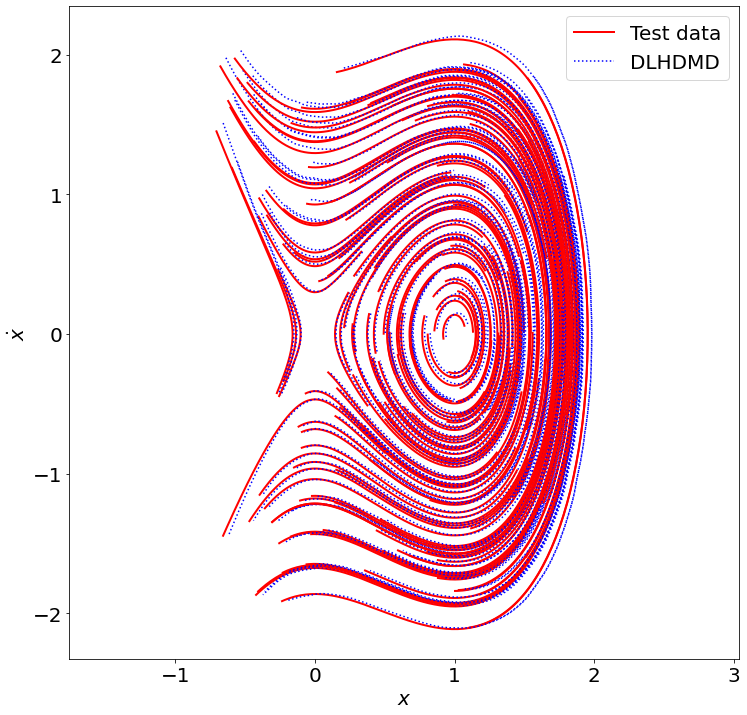

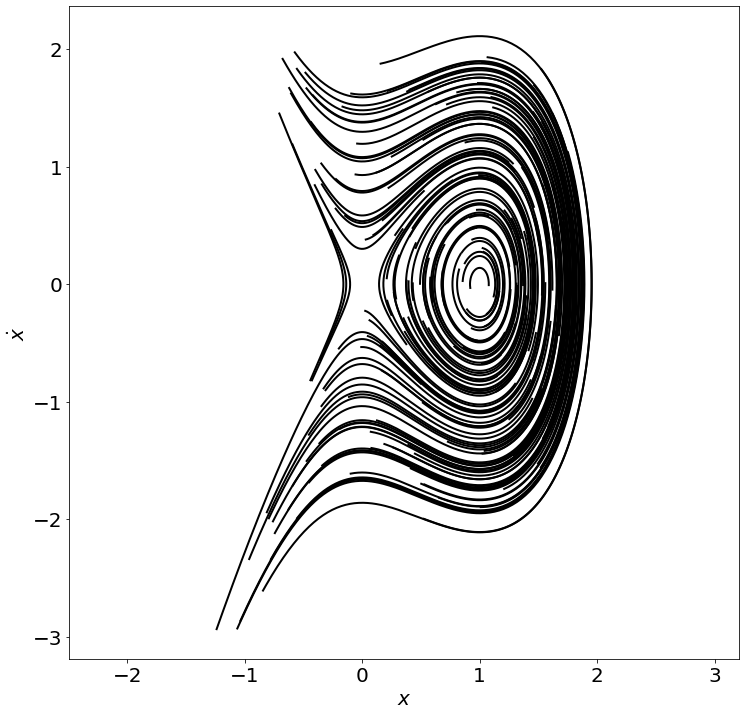

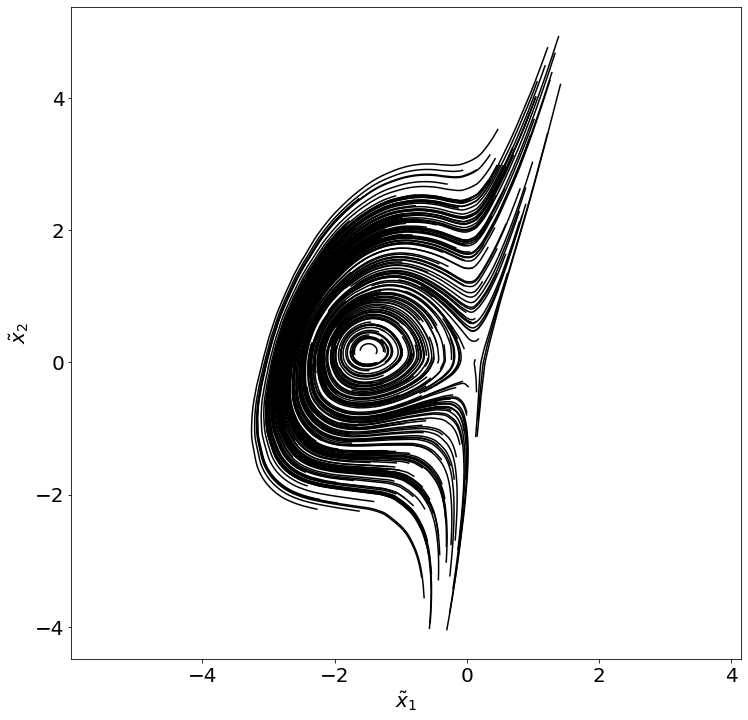

In [31]:
fs = 20
ts = 20
lw = 2.0
ms = 20.0
figsize = (12, 12)
skip = 2

pred = x_adv.shape[1]

# DLHDMD reconstruction
fig = plt.figure(1, figsize=figsize)
for ii in range(0, test_data.shape[0], skip):
    plt.plot(test_data[ii, :pred, 0], test_data[ii, :pred, 1], color='red', linestyle='solid', lw=lw)
    plt.plot(x_adv[ii, :, 0], x_adv[ii, :, 1], color='blue', linestyle='dotted', ms=ms)
plt.plot(test_data[ii, :pred, 0], test_data[ii, :pred, 1], color='red', linestyle='solid', lw=lw, label='Test data')
plt.plot(x_adv[ii, 0, 0], x_adv[ii, 0, 1], color='blue', linestyle='dotted', ms=20*ms, label='DLHDMD')
plt.xlabel(r'$x$', fontsize=fs)
plt.ylabel(r'$\dot{x}$', fontsize=fs)
plt.legend(fontsize=fs, loc='upper right')
plt.axis('equal')
ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=ts)
ax.tick_params(axis='both', which='minor', labelsize=ts)
# plt.savefig("reconstruction_kdv.png")

# DMD reconstruction
# fig = plt.figure(2, figsize=figsize)
# for ii in range(0, test_data.shape[0], skip):
#     plt.plot(test_data[ii, :, 0], test_data[ii, :, 1], 'k', linestyle='solid', lw=lw)
#     plt.plot(x_pred[ii, :, 0], x_pred[ii, :, 1], 'k', linestyle='dotted', ms=ms)
# plt.plot(test_data[ii, :, 0], test_data[ii, :, 1], 'k', linestyle='solid', lw=lw, label='Test data')
# plt.plot(x_pred[ii, 0, 0], x_pred[ii, 0, 1], 'k', linestyle='dotted', ms=20*ms, label='DMD')
# plt.xlabel(r'$x$', fontsize=fs)
# plt.ylabel(r'$\dot{x}$', fontsize=fs)
# plt.legend(fontsize=fs)
# plt.axis('equal')
# ax = plt.gca()
# ax.tick_params(axis='both', which='major', labelsize=ts)
# ax.tick_params(axis='both', which='minor', labelsize=ts)

# Plot the trajectories in phase space and latent space
fig = plt.figure(3, figsize=figsize)
for ii in range(0, test_data.shape[0], skip):
    plt.plot(test_data[ii, :, 0], test_data[ii, :, 1], 'k', linestyle='solid', lw=lw)
plt.xlabel(r'$x$', fontsize=fs)
plt.ylabel(r'$\dot{x}$', fontsize=fs)
plt.axis('equal')
ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=ts)
ax.tick_params(axis='both', which='minor', labelsize=ts)

# Plot the trajectories in latent space
fig = plt.figure(4, figsize=figsize)
for ii in range(y_adv.shape[0]):
    plt.plot(y[ii, :, 0], y[ii, :, 1], 'k', linestyle='solid', ms=ms)
plt.xlabel(r'$\tilde{x}_{1}$', fontsize=fs)
plt.ylabel(r'$\tilde{x}_{2}$', fontsize=fs)
plt.axis('equal')
ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=ts)
ax.tick_params(axis='both', which='minor', labelsize=ts)
# plt.savefig("latent_kdv.png")

plt.show()